In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import math

pd.options.display.max_colwidth = None
import warnings
warnings.filterwarnings('ignore')

# custom functions
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load the wrangled data

In [2]:
train = pd.read_pickle("../data/train.pkl")
test = pd.read_pickle("../data/test.pkl") # for getting val length
train.head()[['title', 'selftext', 'target']]

,title,selftext,target
607641,Overheard At Our Diner,Girl: Ick! Why does this sandwich have bacon on it? Friend: You ordered a BLT. Girl: Whaaaat? I thought the B stood for bread.,False
900322,I failed my chemistry lab exam.,I was in the middle of performing a chemical reaction but I got sued by the Fine Bros.,True
617493,Prison may be just one word,"But to others, it's a whole sentence",True
759877,Why did the dentist vote for Trump?,He likes to keep things white and straight.,True
554037,"I heard that in London, someone gets stabbed every 50 seconds.",Poor guy,False


## Explore the Curated DataFrame

In [3]:
# some useful boolean masks
is_funny = train['target'] == True

In [4]:
# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext']].sample(10)

,title,selftext
775155,What do you call Jehova's Witnesses in Chinese,Ding Dong
947459,TIL you can get dishonorably discharged from the Navy for boarding the wrong vessel just once,Whoops wrong sub
327709,Who Wants to Learn Roman Numerals??,"Well, I for one.."
312017,What do you call a book club that has been stuck on the same book for decades?,Church
770554,What is heavy forwards and not backwards?,ton
974139,At the 3rd grade violin rehearsal ...,"... Donnie Corleone Jr. walks in, opens his violin case and unveils, to the shock of all, a tommy gun. The teachers are livid, panic nearly ensues, but Donnie just starts laughing uncontrollably. ""What's wrong with you? This is serious! Why are you laughing?"" ""Because I just imagined dad holding up the bank with my violin."""
81704,"Dad, why did you name the new baby Teresa?","Well son, Teresa is an anagram. If you rearrange the letters, it spells Easter. -Oh, so you named her that on account of how much you and mom love Easter. Yes, thats right, Alan. -Thanks, Dad!"
494799,Working at home sucks...,....if youre a firefighter.
831345,I've started a business building yachts in my attic,Sails are going through the roof!
946297,Pink Panther's TODO list,1. TODO 2. TODO 3. TODO TODO TODO TODO TODOOO


In [5]:
# The funniest joke(s)
train[train['score'] == train['score'].max()][['title', 'selftext', 'score']]

,title,selftext,score
511072,Calm down about the Net Neutrality thing...,Paying additional money to access certain sites will give you a sense of pride and accomplishment.,136359


In [6]:
# The least funny funny joke(s)
train[train['score'] == train[is_funny]['score'].min()][['title', 'selftext', 'score']]

,title,selftext,score
700042,There's a rumor going around that someone in my group of friends is gay...,"I hope it's Josh, he's pretty cute.",18
403528,Football gave me traumatic brain injury,And I was only watching.,18
242458,What's the difference between John Wayne and Jack Daniels,Jack Daniels is still killing indians,18
440618,Dark Jokes are like food.,Not everyone gets it.,18
61330,Your annual reminder that computer programmers cannot tell Christmas from Halloween,because DEC = OCT,18
...,...,...,...
32662,Grandma fought hard to be cremated.,She urned it.,18
845858,What do you call a reptile that likes to start fights,The Insti-Gator,18
481559,"If Bigamy is having one wife too many, what is Monogamy?",The same thing!,18
621814,Obesity,"Obesity is not because it runs in the family. It is because, no one runs in the family.!!",18


In [7]:
# examples of not funny jokes
train[train['score'] == 0][['title', 'selftext']].sample(10)

,title,selftext
324778,What does VEGAN mean?,*V*ery *E*nergetic if *G*iven *A*nymore *N*utrients
450596,Found out that I'm bad with English idioms from a buzzfeed quiz,That news came out of the purple for me.
812193,What to Russian Zombie Athletes want?,GAINZZZZZZ
244340,"What's my Wife's deal? I remembered the stroller, the diapers, the baby food, hell even the pacifier...",And *ALL* she can talk about is how I forgot the baby.
998478,Whom does Ban Ki-Moon revolve around?,Ban Ki-Earth.
331018,Old/new joke about Negroes,What do you call a traffic jam in Harlem? A blood clot. Where do you go to fix it? Statin Island
404839,I tried to make a joke once. All I could say was...,"""Boooooo!!!!"""
252171,Why did the piccolo player get high before his date?,Because he wanted to go out on a high note
205739,What did the cannibal say about Endgame?,Extra Crispy.
996834,What's in a Paul Walker shot ?,An Irish car bomb followed by a shot of Fireball


Saving figure density plot of log title length


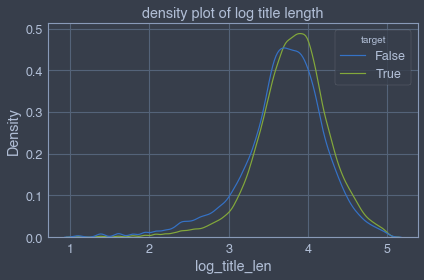

Saving figure density plot of log selftext length


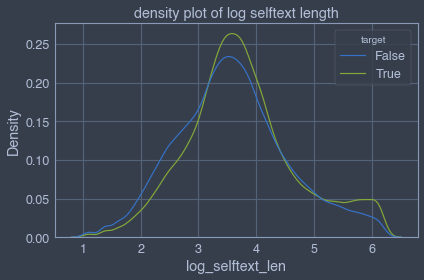

In [8]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()


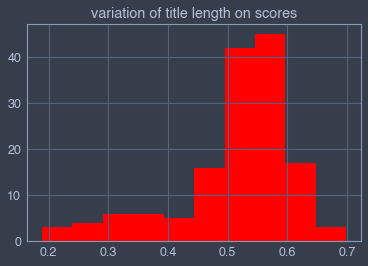

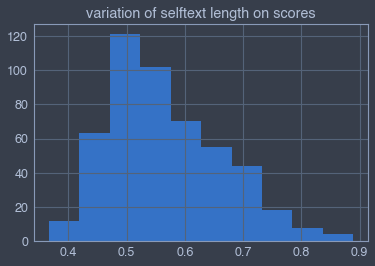

In [9]:
train.groupby(['title_len']).mean()['target'].hist(color='red')
plt.title('variation of title length on scores')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores')
plt.show()

## Examine Time Series Data

In [10]:
# making unix created_times into readable timestamps
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].set_index('created_at', drop=True).sort_index()
df_not_funny = train[~is_funny].set_index('created_at', drop=True).sort_index()

Saving figure submissions over time


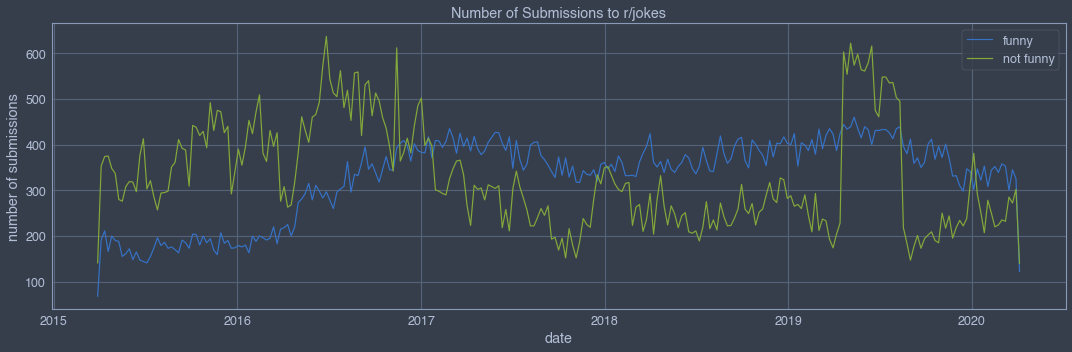

In [11]:
# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

Saving figure average submission per hour


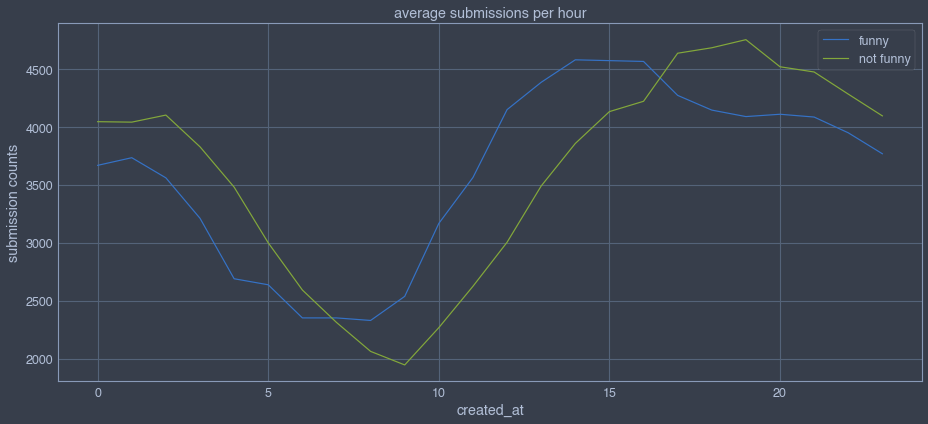

In [12]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

<AxesSubplot:xlabel='created_at', ylabel='type'>

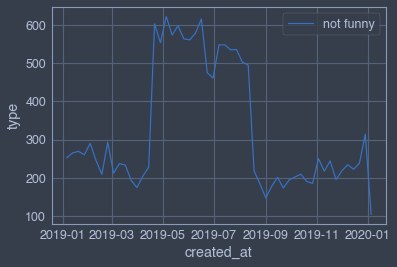

In [13]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')

In [14]:
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date), str(end_date)
print(start_date_not_funny_event, end_date_not_funny_event)

2019-04-07 00:00:00 2019-09-01 00:00:00


In [15]:
# examine difference in that text vs another
not_funny_anom_df = df_not_funny.loc[start_date_not_funny_event:end_date_not_funny_event]

# get samples from same dataset up to that event
not_funny_norm_df = df_not_funny.loc[:start_date_not_funny_event][-len(not_funny_anom_df):]

### Preprocessing
The goal of preprocessing is to both clean and *normalize* strings that will then be further processed into vectors fed into a model. form that can then fed into a model. can refed in as input into a model. In the unprocessed text, the words "run" and "runs" are treated as distinct tokens by the model, despite the latter being former's plural form. During the preprocessing, it is assumed that not much context of the document will be lost if words stemming from the same word root from the same stem as the same. e.g. for the verb jump, normalizing the text would treat all of the following...



In [16]:
# # take smaller subsample of data for analysis
# funny, not_funny = train[is_funny].sample(frac=.1), train[~is_funny].sample(frac=.1)
# data = pd.concat([funny, not_funny], axis=0)
# data.sample(frac=1)
# data.head()

In [17]:
# for ease of processing all text data in a row
train['all_text'] = train['title'] + " " + train['selftext']
# boolean mask
is_funny = train['target'] == True
# preprocess text for analysis
train['processed_text'] = train['all_text'].apply(lambda x: preprocess_text(x, stop_words='default', flg_stemm=True, flg_lemm=False))
VAL_SIZE = len(test)
train, val = train[VAL_SIZE:], train[:VAL_SIZE]

## Funny / Not-Funny n-Grams

In [18]:
train[['all_text','processed_text']].sample(15)

,all_text,processed_text
631402,"An American, a Russian and an Estonian are on a plane The American opens the door and drops some hamburgers and then says: ""I have too many of these"". Then the Russian goes to the Door and throws down some bottles of vodka and says: ""I have too many of them"". Then the Estonia comes and throws down the Russian and says: ""I have too many of them"".",american russian estonian plane american open door drop hamburg say mani russian goe door throw bottl vodka say mani estonia come throw russian say mani
771052,"A Greek, a Spaniard and a Portuguese all walk into a bar. Who pays? Germany.",greek spaniard portugues walk bar pay germani
729428,Did you see about that blind guy who got hit by a bus? Cause he sure didn't,see blind guy got hit bu caus sure didnt
422442,"NASA Reveals New Roadmap, Will Begin Work On Lunar Space Station In 2019 We will begin by building a wall on the moon.",nasa reveal new roadmap begin work lunar space station 2019 begin build wall moon
947974,Hoarding's great. Collectively speaking.,hoard great collect speak
244749,Have you ever heard about German humour? NEINther have I,ever heard german humour neinther
457846,"An 18 year old in America is allowed to buy an AR-15, vote, enlist in the army, buy cigarettes, get a lottery ticket, and die for their country... ...but god FORBID they try to rent a car.",18 year old america allow buy ar15 vote enlist armi buy cigarett get lotteri ticket die countri god forbid tri rent car
583632,"A dog walks into a bar The dog says, ""Gimme a beer."" The bartender says, ""Wow! You can talk! You should get a job at the circus!"" The dog says, ""They're hiring electricians at the circus?""",dog walk bar dog say gimm beer bartend say wow talk get job circu dog say theyr hire electrician circu
431737,What do you call an animal that got its horn cut off ? A Eunuchorn,call anim got horn cut eunuchorn
910414,How does the moon cut his hair? 'Eclipse it.,moon cut hair eclips


### Creating a BOW Model

In [19]:
# Get the vocabulary
vocab = list(set([word for sentence in train['processed_text'].values for word in sentence.split()]))

# get pos (funny) and neg (not funny) tokens
funny_tokens = [word for sentence in train[is_funny]['processed_text'].values for word in sentence.split()]
not_funny_tokens = [word for sentence in train[~is_funny]['processed_text'].values for word in sentence.split()]

# create word freq dictionary
def word_freq_dict(tokens, vocab):
    word_freq_dict = dict(zip(vocab, np.zeros((len(vocab)), int)))
    for token in tokens:
        if token in word_freq_dict.keys():
            word_freq_dict[token] += 1
    return word_freq_dict
    

# get word frequencies
funny_word_freq = word_freq_dict(funny_tokens, vocab)
not_funny_word_freq = word_freq_dict(not_funny_tokens, vocab)

# build dataframe to specifications
funny_freq_df = pd.DataFrame({'word':list(funny_word_freq.keys()),
                            'freq':list(funny_word_freq.values())}).set_index('word')

not_funny_freq_df = pd.DataFrame({'word':list(not_funny_word_freq.keys()),
                            'freq':list(not_funny_word_freq.values())}).set_index('word')

freq_df = pd.merge(funny_freq_df, not_funny_freq_df, on='word', suffixes=('_funny', '_not_funny'))
freq_df

,freq_funny,freq_not_funny
word,,
bthe,0,1
ukrain,28,16
liftman,1,0
5x3,1,0
addth,0,1
...,...,...
creation,13,11
littleknown,0,1
oldfashion,2,3


### Most Probable N-Gram(s)

In [20]:
# Frequency 
# conditional probability table (with Laplacian Smoothing)
cond_prob_df = (freq_df + 1) / (freq_df.sum() + len(vocab))
cond_prob_df.columns = ['prob_funny', 'prob_not_funny']
cond_prob_df['ratio'] = cond_prob_df.iloc[:,0] / cond_prob_df.iloc[:,1]
cond_prob_df['lambda'] = np.log(cond_prob_df['ratio'])
display(cond_prob_df.sort_values(by='ratio', ascending=False))

# apply log likelihood values to training data
def get_log_likelihood(text, cond_prod_df):
    log_likelihood = 0
    for word in text.split():
        if word in cond_prob_df.index:
            log_likelihood += cond_prob_df['lambda'].loc[word]
    return log_likelihood

# calculate log likelihood and determine predictions on training data
train['log_likelihood'] = train['processed_text'].apply(lambda x: get_log_likelihood(x, cond_prob_df))
train['sigmoid'] = train['log_likelihood'].apply(lambda x: 1 / (1 + np.exp(-x)))
train['predictions'] = train['sigmoid'].apply(lambda x: True if x >0.5 else False)
accuracy = (train['target'] == train['predictions']).sum() / len(train)
print(f"training accuracy: {accuracy}")

# calculate log likelihood and determine predictions on training data
val['log_likelihood'] = val['processed_text'].apply(lambda x: get_log_likelihood(x, cond_prob_df))
val['sigmoid'] = val['log_likelihood'].apply(lambda x: 1 / (1 + np.exp(-x)))
val['predictions'] = val['sigmoid'].apply(lambda x: True if x >0.5 else False)
accuracy = (val['target'] == val['predictions']).sum() / len(val)
print(f"validation accuracy: {accuracy}")

,prob_funny,prob_not_funny,ratio,lambda
word,,,,
rorschach,2.751148e-05,0.000001,26.555205,3.279226
repay,2.567738e-05,0.000001,24.784858,3.210233
dhabi,4.952066e-05,0.000002,23.899685,3.173865
marxman,2.384328e-05,0.000001,23.014511,3.136125
denephew,2.200918e-05,0.000001,21.244164,3.056082
...,...,...,...,...
bo,9.170492e-07,0.000027,0.034045,-3.380068
welfar,9.170492e-07,0.000028,0.032784,-3.417808
booger,9.170492e-07,0.000029,0.031613,-3.454176


training accuracy: 0.7147819081866156
validation accuracy: 0.6624713958810069


In [21]:
# Term Frequency - Inverse Doc Frequency 
inv_freq_vectorizer = TfidfVectorizer(preprocessor=preprocess_text)

inv_freq_vectorizer.fit(train['all_text'])
funny_mat = inv_freq_vectorizer.transform(train[is_funny]['all_text'])
not_funny_mat = inv_freq_vectorizer.transform(train[~is_funny]['all_text'])

sum_words_funny_if = funny_mat.sum(axis=0)
sum_words_not_funny_if = not_funny_mat.sum(axis=0)

words_freq_funny_if = [(word, sum_words_funny_if[0,i]) for word, i in inv_freq_vectorizer.vocabulary_.items()]
words_freq_not_funny_if = [(word, sum_words_not_funny_if[0,i]) for word, i in inv_freq_vectorizer.vocabulary_.items()]

funny_inv_freq_df = pd.DataFrame(words_freq_funny_if, columns=['word', 'freq'])
not_funny_inv_freq_df = pd.DataFrame(words_freq_not_funny_if, columns=['word', 'freq'])

inv_freq_df = pd.merge(funny_inv_freq_df, not_funny_inv_freq_df, on='word', suffixes=('_funny', '_not_funny')).set_index('word', drop=True)
inv_freq_df

,freq_funny,freq_not_funny
word,,
free,109.388064,105.141017
time,560.225460,461.896146
what,1859.274428,2382.380723
do,1776.555849,1955.330213
you,2788.565821,2838.021504
...,...,...
dormant,0.491551,0.000000
acoss,0.000000,0.478647
obliterates,0.132826,0.000000


In [22]:
# Inverse Frequency
# conditional probability table (with Laplacian Smoothing)
cond_prob_df = (inv_freq_df + 1) / (inv_freq_df.sum() + len(inv_freq_vectorizer.vocabulary_))
cond_prob_df.columns = ['prob_funny', 'prob_not_funny']
cond_prob_df['ratio'] = cond_prob_df.iloc[:,0] / cond_prob_df.iloc[:,1]
cond_prob_df['lambda'] = np.log(cond_prob_df['ratio'])
display(cond_prob_df.sort_values(by='ratio', ascending=False))

# apply log likelihood values to training data
def get_log_likelihood(text, cond_prod_df):
    log_likelihood = 0
    for word in text.split():
        if word in cond_prob_df.index:
            log_likelihood += cond_prob_df['lambda'].loc[word]
    return log_likelihood

# calculate log likelihood and determine predictions on training data
train['log_likelihood'] = train['processed_text'].apply(lambda x: get_log_likelihood(x, cond_prob_df))
train['sigmoid'] = train['log_likelihood'].apply(lambda x: 1 / (1 + np.exp(-x)))
train['predictions'] = train['sigmoid'].apply(lambda x: True if x >0.5 else False)
accuracy = (train['target'] == train['predictions']).sum() / len(train)
print(f"training accuracy: {accuracy}")

# calculate log likelihood and determine predictions on training data
val['log_likelihood'] = val['processed_text'].apply(lambda x: get_log_likelihood(x, cond_prob_df))
val['sigmoid'] = val['log_likelihood'].apply(lambda x: 1 / (1 + np.exp(-x)))
val['predictions'] = val['sigmoid'].apply(lambda x: True if x >0.5 else False)
accuracy = (val['target'] == val['predictions']).sum() / len(val)
print(f"validation accuracy: {accuracy}")

,prob_funny,prob_not_funny,ratio,lambda
word,,,,
seashell,0.000059,0.000004,15.800453,2.760039
marxman,0.000042,0.000003,14.946474,2.704475
sluggish,0.000040,0.000003,12.350023,2.513658
rorschach,0.000034,0.000003,12.240762,2.504771
dhabi,0.000043,0.000004,12.108213,2.493884
...,...,...,...,...
xd,0.000005,0.000071,0.077146,-2.562050
adele,0.000008,0.000113,0.072377,-2.625873
dank,0.000003,0.000039,0.068268,-2.684313


training accuracy: 0.6760262457385701
validation accuracy: 0.6475972540045767


### Title and Selftext

In [23]:
train['processed_title'] = train['title'].apply(lambda x:  preprocess_text(x))
train['processed_selftext'] = train['selftext'].apply(lambda x: preprocess_text(x))

## All text

Saving figure most common ngrams


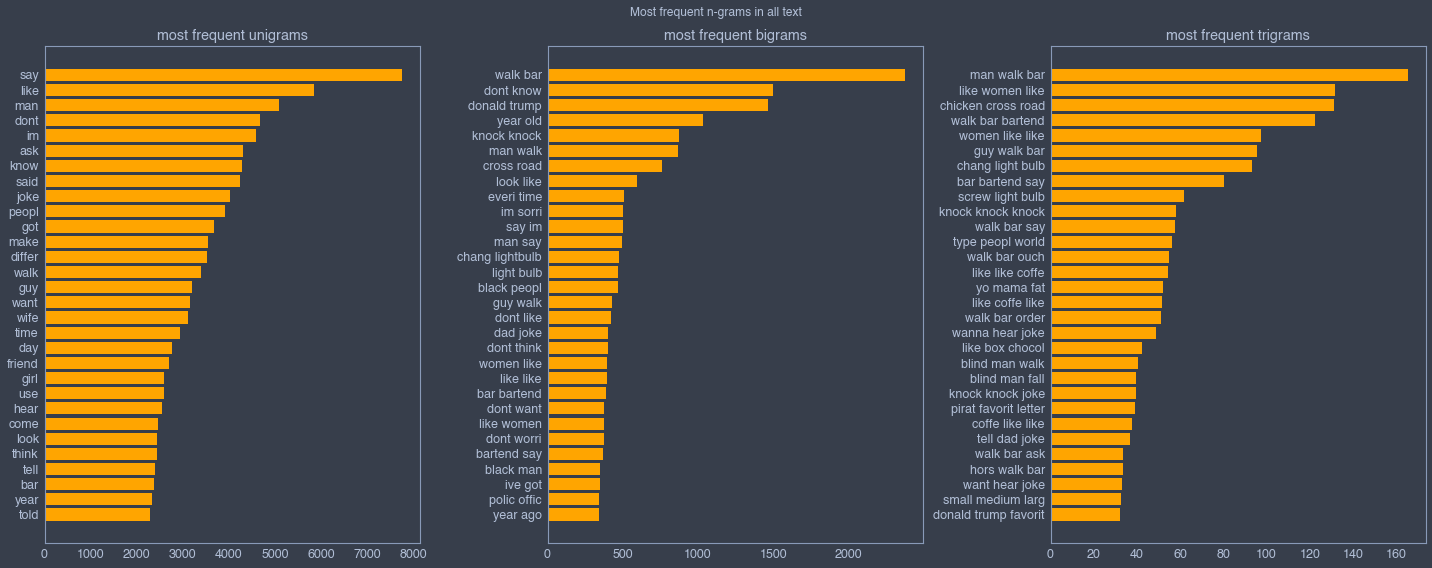

In [46]:
# Most frequent words
# unigrams
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
tfidf_unigrams, cv_if_unigrams, df_freq_unigrams = inv_freq(train['processed_text'], stop_words = 'english', min_df=0.01, max_df=.85, nmin=1, nmax=1)
df = df_freq_unigrams.head(30).sort_values(by='freq')
ax[0].barh(df['word'], df['freq'], color='orange')
ax[0].grid(False)
ax[0].set_title('most frequent unigrams')
#plt.show()

# bigrams
tfidf_bigrams, cv_if_bigrams, df_freq_bigrams = inv_freq(train['processed_text'], stop_words = 'english', min_df=0.001, max_df=.99, nmin=2, nmax=2)
df = df_freq_bigrams.head(30).sort_values(by='freq')
ax[1].barh(df['word'], df['freq'], color='orange')
ax[1].grid(False)
ax[1].set_title('most frequent bigrams')
#plt.show()

# trigrams
tfidf_trigrams, cv_if_trigrams, df_freq_trigrams = inv_freq(train['processed_text'], stop_words = 'english', min_df=0.00, max_df=1.0, nmin=3, nmax=3)
df = df_freq_trigrams.head(30).sort_values(by='freq')
ax[2].barh(df['word'], df['freq'], color='orange')
ax[2].grid(False)
ax[2].set_title('most frequent trigrams')
plt.tight_layout()
plt.suptitle('Most frequent n-grams in all text')
save_fig('most common ngrams')
plt.show()

Saving figure most frequent unigrams


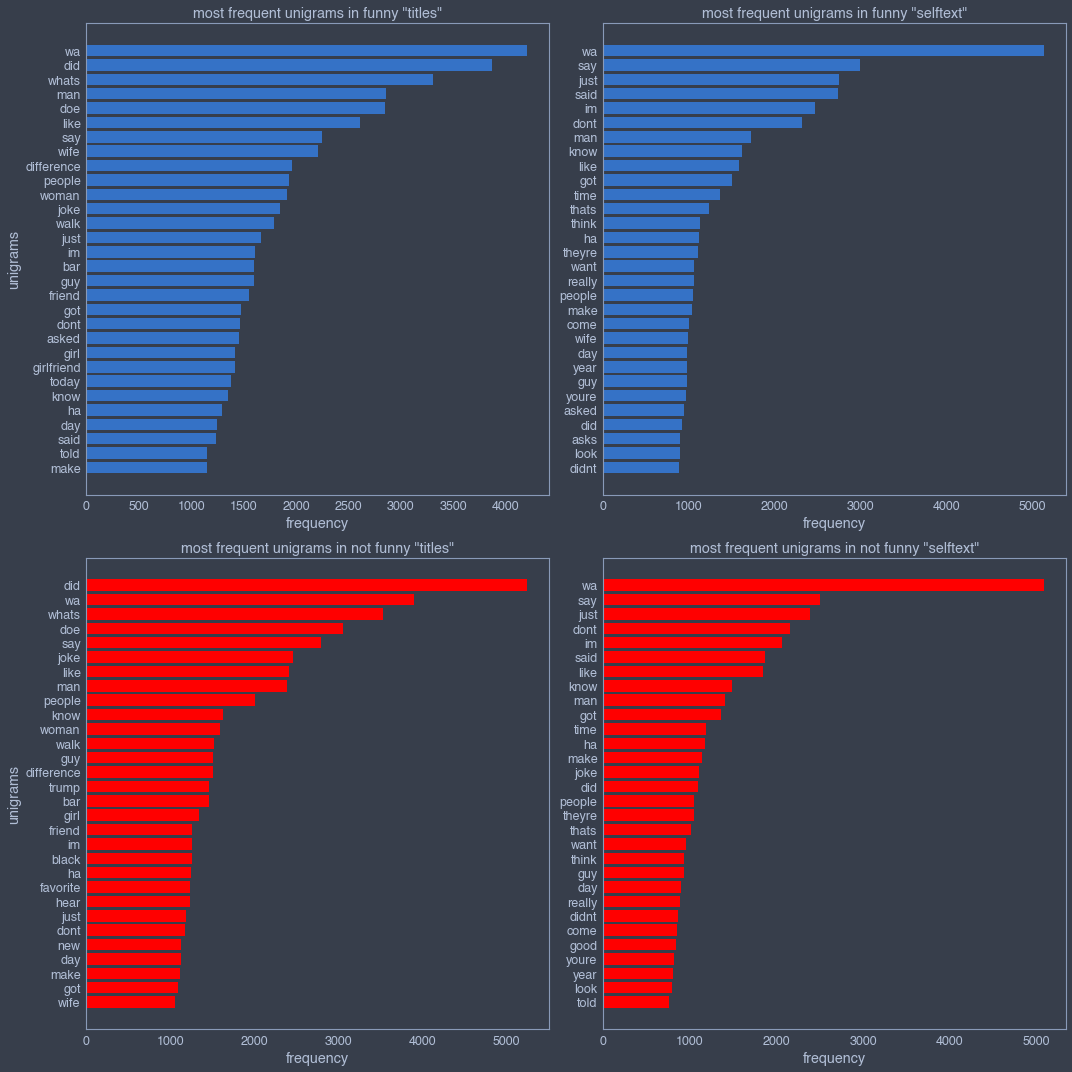

In [52]:
# unigrams title and selftext funny
tfidf_unigrams_title_funny, cv_if_unigrams_title_funny, df_freq_unigrams_title_funny = inv_freq(train[is_funny]['processed_title'], stop_words = 'english', min_df=0.01, max_df=0.95, nmin=1, nmax=1)
tfidf_unigrams_selftext_funny, cv_if_unigrams_selftext_funny, df_freq_unigrams_selftext_funny = inv_freq(train[is_funny]['processed_selftext'], stop_words = 'english', min_df=0.01, max_df=0.95, nmin=1, nmax=1)
tfidf_unigrams_title_not_funny, cv_if_unigrams_title_not_funny, df_freq_unigrams_title_not_funny = inv_freq(train[~is_funny]['processed_title'], stop_words = 'english', min_df=0.01, max_df=0.95, nmin=1, nmax=1)
tfidf_unigrams_selftext_not_funny, cv_if_unigrams_selftext_not_funny, df_freq_unigrams_selftext_not_funny = inv_freq(train[~is_funny]['processed_selftext'], stop_words = 'english', min_df=0.01, max_df=0.95, nmin=1, nmax=1)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

df1 = df_freq_unigrams_title_funny.head(30).sort_values(by='freq')
df2 = df_freq_unigrams_selftext_funny.head(30).sort_values(by='freq')
df3 = df_freq_unigrams_title_not_funny.head(30).sort_values(by='freq')
df4 = df_freq_unigrams_selftext_not_funny.head(30).sort_values(by='freq')

ax[0,0].barh(df1['word'], df1['freq'])
ax[0,0].set_title('most frequent unigrams in funny "titles"')
ax[0,0].set_ylabel('unigrams')
ax[0,0].set_xlabel('frequency')
ax[0,0].grid(False)

ax[0,1].barh(df2['word'], df2['freq'])
ax[0,1].set_title('most frequent unigrams in funny "selftext"')
ax[0,1].set_xlabel('frequency')
ax[0,1].grid(False)

ax[1,0].barh(df3['word'], df3['freq'], color='red')
ax[1,0].set_title('most frequent unigrams in not funny "titles"')
ax[1,0].set_ylabel('unigrams')
ax[1,0].set_xlabel('frequency')
ax[1,0].grid(False)

ax[1,1].barh(df4['word'], df4['freq'], color='red')
ax[1,1].set_title('most frequent unigrams in not funny "selftext"')
ax[1,1].set_xlabel('frequency')
ax[1,1].grid(False)

plt.tight_layout()
save_fig('most frequent unigrams')
plt.show()

Saving figure most frequent bigrams


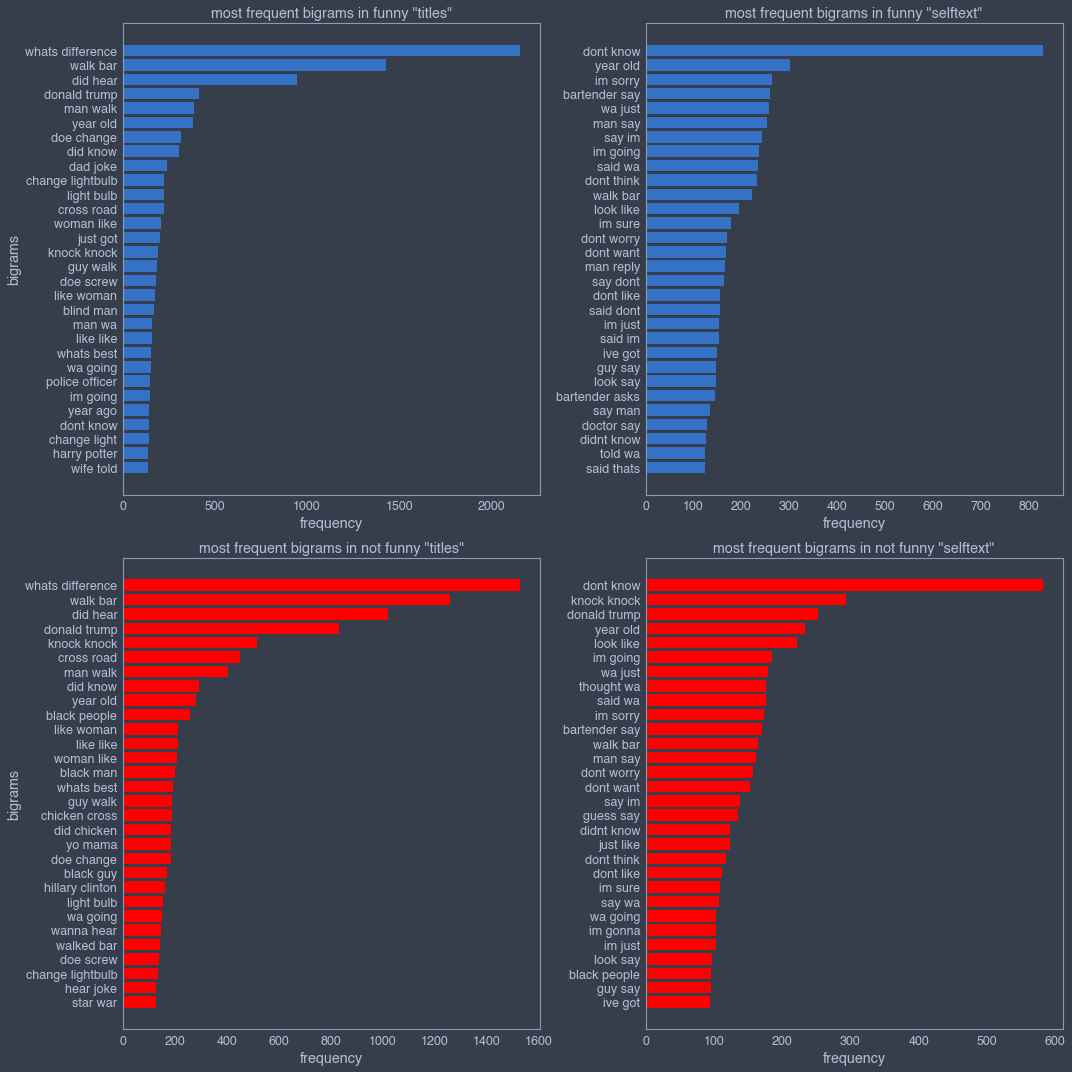

In [53]:
# bigrams title and selftext 
tfidf_bigrams_title_funny, cv_if_bigrams_title_funny, df_freq_bigrams_title_funny = inv_freq(train[is_funny]['processed_title'], stop_words = 'english', min_df=0.001, max_df=0.99, nmin=2, nmax=2)
tfidf_bigrams_selftext_funny, cv_if_bigrams_selftext_funny, df_freq_bigrams_selftext_funny = inv_freq(train[is_funny]['processed_selftext'], stop_words = 'english', min_df=0.001, max_df=0.99, nmin=2, nmax=2)
tfidf_bigrams_title_not_funny, cv_if_bigrams_title_not_funny, df_freq_bigrams_title_not_funny = inv_freq(train[~is_funny]['processed_title'], stop_words = 'english', min_df=0.001, max_df=0.99, nmin=2, nmax=2)
tfidf_bigrams_selftext_not_funny, cv_if_bigrams_selftext_not_funny, df_freq_bigrams_selftext_not_funny = inv_freq(train[~is_funny]['processed_selftext'], stop_words = 'english', min_df=0.001, max_df=0.99, nmin=2, nmax=2)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

df1 = df_freq_bigrams_title_funny.head(30).sort_values(by='freq')
df2 = df_freq_bigrams_selftext_funny.head(30).sort_values(by='freq')
df3 = df_freq_bigrams_title_not_funny.head(30).sort_values(by='freq')
df4 = df_freq_bigrams_selftext_not_funny.head(30).sort_values(by='freq')

ax[0,0].barh(df1['word'], df1['freq'])
ax[0,0].set_title('most frequent bigrams in funny "titles"')
ax[0,0].set_ylabel('bigrams')
ax[0,0].set_xlabel('frequency')
ax[0,0].grid(False)

ax[0,1].barh(df2['word'], df2['freq'])
ax[0,1].set_title('most frequent bigrams in funny "selftext"')
ax[0,1].set_xlabel('frequency')
ax[0,1].grid(False)

ax[1,0].barh(df3['word'], df3['freq'], color='red')
ax[1,0].set_title('most frequent bigrams in not funny "titles"')
ax[1,0].set_ylabel('bigrams')
ax[1,0].set_xlabel('frequency')
ax[1,0].grid(False)

ax[1,1].barh(df4['word'], df4['freq'], color='red')
ax[1,1].set_title('most frequent bigrams in not funny "selftext"')
ax[1,1].set_xlabel('frequency')
ax[1,1].grid(False)

plt.tight_layout()
save_fig('most frequent bigrams')
plt.show()

Saving figure most frequent trigrams


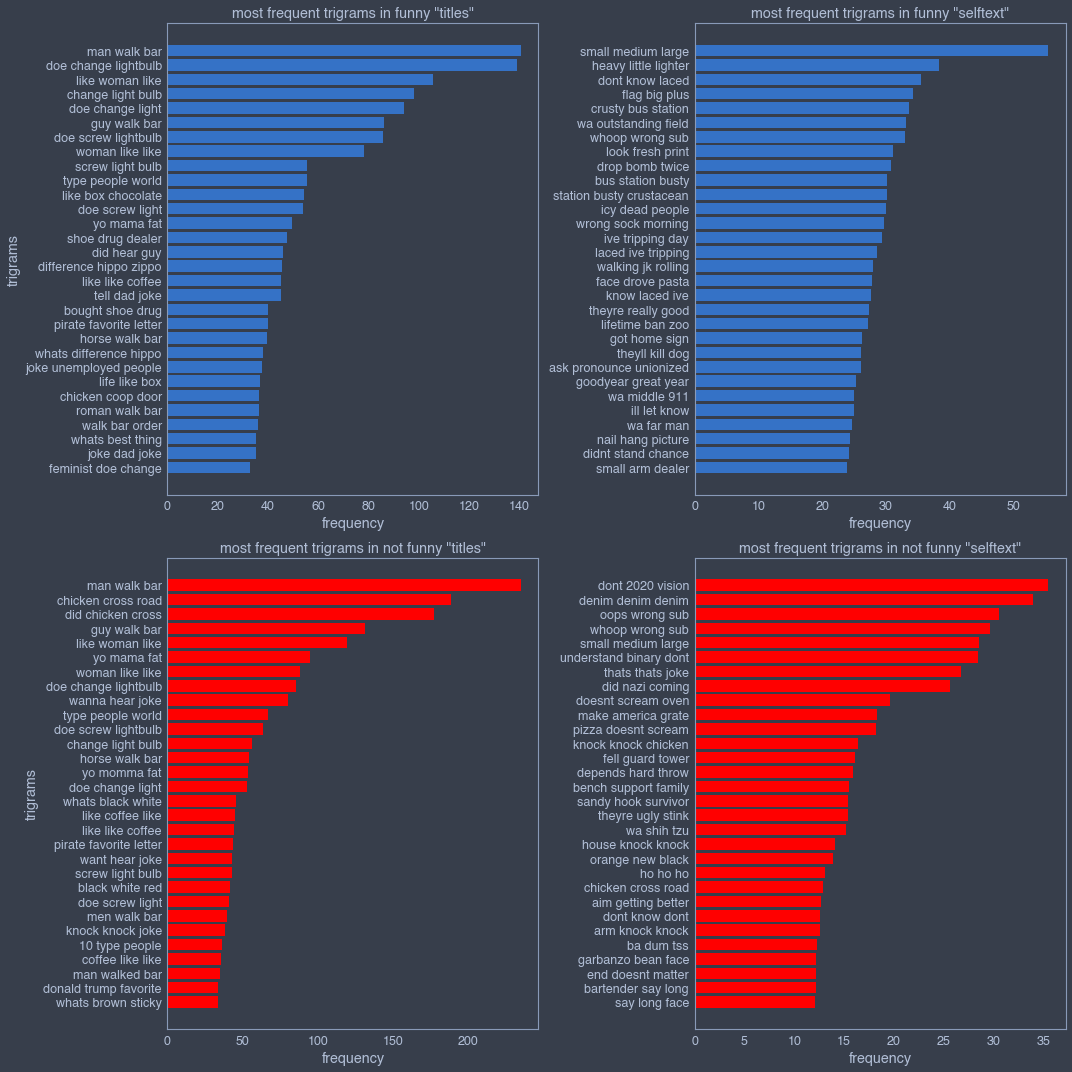

In [54]:
# trigrams title and selftext 
tfidf_trigrams_title_funny, cv_if_trigrams_title_funny, df_freq_trigrams_title_funny = inv_freq(train[is_funny]['processed_title'], stop_words = 'english', min_df=0.00, max_df=1.0, nmin=3, nmax=3)
tfidf_trigrams_selftext_funny, cv_if_trigrams_selftext_funny, df_freq_trigrams_selftext_funny = inv_freq(train[is_funny]['processed_selftext'], stop_words = 'english', min_df=0.00, max_df=1.0, nmin=3, nmax=3)
tfidf_trigrams_title_not_funny, cv_if_trigrams_title_not_funny, df_freq_trigrams_title_not_funny = inv_freq(train[~is_funny]['processed_title'], stop_words = 'english', min_df=0.00, max_df=1.0, nmin=3, nmax=3)
tfidf_trigrams_selftext_not_funny, cv_if_trigrams_selftext_not_funny, df_freq_trigrams_selftext_not_funny = inv_freq(train[~is_funny]['processed_selftext'], stop_words = 'english', min_df=0.00, max_df=1.0, nmin=3, nmax=3)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

df1 = df_freq_trigrams_title_funny.head(30).sort_values(by='freq')
df2 = df_freq_trigrams_selftext_funny.head(30).sort_values(by='freq')
df3 = df_freq_trigrams_title_not_funny.head(30).sort_values(by='freq')
df4 = df_freq_trigrams_selftext_not_funny.head(30).sort_values(by='freq')

ax[0,0].barh(df1['word'], df1['freq'])
ax[0,0].set_title('most frequent trigrams in funny "titles"')
ax[0,0].set_ylabel('trigrams')
ax[0,0].set_xlabel('frequency')
ax[0,0].grid(False)

ax[0,1].barh(df2['word'], df2['freq'])
ax[0,1].set_title('most frequent trigrams in funny "selftext"')
ax[0,1].set_xlabel('frequency')
ax[0,1].grid(False)


ax[1,0].barh(df3['word'], df3['freq'], color='red')
ax[1,0].set_title('most frequent trigrams in not funny "titles"')
ax[1,0].set_ylabel('trigrams')
ax[1,0].set_xlabel('frequency')
ax[1,0].grid(False)

ax[1,1].barh(df4['word'], df4['freq'], color='red')
ax[1,1].set_title('most frequent trigrams in not funny "selftext"')
ax[1,1].set_xlabel('frequency')
ax[1,1].grid(False)

plt.tight_layout()
save_fig('most frequent trigrams')
plt.show()